In [1]:
# Importing relevant libraries and defining the Net class (same class with which the networks were generated)
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pickle
from numpy.random import RandomState
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from typing import Any, Callable, Optional, Tuple
from torchvision import datasets, transforms
import torch.nn.functional as F
import quadprog
import copy

from utils import LinCKA2

In [2]:
# Network class
k=1
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Sequential(nn.Conv2d(3, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True)), nn.Sequential(nn.Conv2d(16*k, 16*k,  kernel_size=3) , nn.BatchNorm2d(16*k),
                      nn.ReLU(inplace=True))] 
        self.layers+=[nn.Sequential(nn.Conv2d(16*k, 32*k,  kernel_size=3, stride=2),  nn.BatchNorm2d(32*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True)),nn.Sequential(nn.Conv2d(32*k, 32*k,  kernel_size=3),  nn.BatchNorm2d(32*k),
              nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(32*k, 64*k,  kernel_size=3, stride=2), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=3, padding='valid'), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+=[nn.Sequential(nn.Conv2d(64*k, 64*k,  kernel_size=1), nn.BatchNorm2d(64*k),
                      nn.ReLU(inplace=True))]
        self.layers+= [nn.AdaptiveAvgPool2d((1,1))]
        self.fc = nn.Linear(64*k, 10)
    
    def forward(self, x, acts_only=False,all_act=False):
        all_acts = []
        for i in range(len(self.layers[:-1])):
#             all_acts.append(x)
            x = self.layers[i](x)
            all_acts.append(x)
        
        x = self.layers[-1](x) #Had to add this since it's not in the loop anymore
        x = self.fc(x.view(-1, 64*k))

        if all_act:
            # all_cts does not return the final output of the network
            return all_acts, x
        return x
    
    def forward_embed(self, x, layer_idx = -1):
#         print(len(self.layers[:layer_idx]))
        for i in range(len(self.layers[:layer_idx])):
             x = self.layers[i](x)
                
        return x

In [3]:
# Importing the saved networks
PATH='net_kornblith_'

net_all1 = Net()
net_all1.load_state_dict(torch.load(PATH+'all_1.zip'))
net_all1.eval()
net_all1.cuda()

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

# Split and train experiment

In [4]:
# Code adapted from Grounding ...
# Added imports
import sklearn.metrics.pairwise as pw


## CCA
def cca_decomp(A, B):
    """Computes CCA vectors, correlations, and transformed matrices
    requires a < n and b < n
    Args:
        A: np.array of size a x n where a is the number of neurons and n is the dataset size
        B: np.array of size b x n where b is the number of neurons and n is the dataset size
    Returns:
        u: left singular vectors for the inner SVD problem
        s: canonical correlation coefficients
        vh: right singular vectors for the inner SVD problem
        transformed_a: canonical vectors for matrix A, a x n array
        transformed_b: canonical vectors for matrix B, b x n array
    """
    assert A.shape[0] < A.shape[1]
    assert B.shape[0] < B.shape[1]

    evals_a, evecs_a = np.linalg.eigh(A @ A.T)
    evals_a = (evals_a + np.abs(evals_a)) / 2
    inv_a = np.array([1 / np.sqrt(x) if x > 0 else 0 for x in evals_a])

    evals_b, evecs_b = np.linalg.eigh(B @ B.T)
    evals_b = (evals_b + np.abs(evals_b)) / 2
    inv_b = np.array([1 / np.sqrt(x) if x > 0 else 0 for x in evals_b])

    cov_ab = A @ B.T

    temp = (
        (evecs_a @ np.diag(inv_a) @ evecs_a.T)
        @ cov_ab
        @ (evecs_b @ np.diag(inv_b) @ evecs_b.T)
    )

    try:
        u, s, vh = np.linalg.svd(temp)
    except:
        u, s, vh = np.linalg.svd(temp * 100)
        s = s / 100

    transformed_a = (u.T @ (evecs_a @ np.diag(inv_a) @ evecs_a.T) @ A).T
    transformed_b = (vh @ (evecs_b @ np.diag(inv_b) @ evecs_b.T) @ B).T
    return u, s, vh, transformed_a, transformed_b


def mean_sq_cca_corr(rho):
    """Compute mean squared CCA correlation
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    """
    # len(rho) is min(A.shape[0], B.shape[0])
    return np.sum(rho * rho) / len(rho) # THESE ARE NOT WRITTEN AS DISTANCES... WTF?


def mean_cca_corr(rho):
    """Compute mean CCA correlation
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    """
    # len(rho) is min(A.shape[0], B.shape[0])
    return np.sum(rho) / len(rho) # THESE ARE NOT WRITTEN AS DISTANCES... WTF?


def pwcca_dist(A, rho, transformed_a):
    """Computes projection weighted CCA distance between A and B given the correlation
    coefficients rho and the transformed matrices after running CCA
    :param A: np.array of size a x n where a is the number of neurons and n is the dataset size
    :param B: np.array of size b x n where b is the number of neurons and n is the dataset size
    :param rho: canonical correlation coefficients returned by cca_decomp(A,B)
    :param transformed_a: canonical vectors for A returned by cca_decomp(A,B)
    :param transformed_b: canonical vectors for B returned by cca_decomp(A,B)
    :return: PWCCA distance
    """
    in_prod = transformed_a.T @ A.T
    weights = np.sum(np.abs(in_prod), axis=1)
    weights = weights / np.sum(weights)
    dim = min(len(weights), len(rho))
#     return 1 - np.dot(weights[:dim], rho[:dim]) # THIS IS WRITTEN AS A DISTANCE
    return np.dot(weights[:dim], rho[:dim])

## Procrustes
def procrustes(A, B):
    """
    Computes Procrustes distance bewteen representations A and B
    """
    A_sq_frob = np.sum(A ** 2)
    B_sq_frob = np.sum(B ** 2)
    nuc = np.linalg.norm(A @ B.T, ord="nuc")  # O(p * p * n)
    return 1-(A_sq_frob + B_sq_frob - 2 * nuc)

## Functions

In [5]:
def get_activations_by_class(data, labels):
    # returns datapoints, a list of class clusters (each element of the list corresponds to all examples from one class)
    # indexes
    indexes = []
    datapoints = []
    
    for label in range(10): #for label in set(labels): 
        indexes.append(np.where(labels==label))
        datapoints.append(data[indexes[-1]])
    
    return datapoints, np.array(indexes).squeeze()

def split_class_clusters(data, indexes, d, W, n_clusters, split_constant, ortho_d = True, experiment = 'one_class_one_point'):
    # data should be of shape n x d (n examples, d features)
    # d is the random direction vector
    # W comes from lin_svc.coef_ (n_classes, n_features) corresponding to the normal vectors to the decision hyperplanes
    data_ = np.copy(data)
    
    if ortho_d:
        Q, R = np.linalg.qr(W.T)
        d_ = d.reshape([1,np.max(d.shape)])
        d_ -= np.matmul(d_, np.matmul(Q, Q.T))
    else:
        d_ = d
    
    projections = np.matmul(data_, d_.T).squeeze()
    mean = np.mean(projections)
    min_ = np.min(projections)
    max_ = np.max(projections)
    
    translations = np.zeros(data_.shape[0])
    
    idxs = []
    separators = np.linspace(min_,max_,n_clusters+1)
    if 'one_point' in experiment: 
        if n_clusters != 2:
            print("ERROR: one point experiment won't work because number of clusters is not 2")
        else:
            separators = np.linspace(min_,max_,n_clusters)
        
    for cluster_idx in range(n_clusters):
        idx = np.where(projections>=separators[cluster_idx])
        if cluster_idx < (n_clusters-1): # Except for last cluster we need to take into account that the projections are not superior to the next separator
            idx2 = idx2 = np.where(projections<separators[cluster_idx+1])
            idx = np.intersect1d(idx, idx2)
        idxs.append(idx)
        translations[idxs[-1]] = cluster_idx*split_constant 
    
    translations = np.matmul(np.diag(translations.squeeze()), np.matmul(np.ones([data_.shape[0],1]), d_))
    
    data_+= translations
    return data_, np.array([indexes[i] for i in idxs]).squeeze()

def translate_class_clusters(data_per_classes, ortho_d, translation_constant, experiment = ''):
    # data should be a list of length num_classes containing n x d (n examples, d features)
    # ortho_d is the random direction vector
    # experiment can be '' or 'one_class_x' with x being the class that we want to translate, or 'one_point' selected at random
    new_data = copy.deepcopy(data_per_classes)
    pt_idx = None
    
    if experiment == 'all_classes':
        for data in new_data:
            data += translation_constant*np.matmul(np.ones([data.shape[0],1]), ortho_d.reshape([1, data.shape[1]]))
        new_data = np.concatenate(new_data)
        
    elif 'one_class' in experiment:
        class_idx = int(experiment.split('_')[2])
        
        for idx, data in enumerate(new_data):
            if idx == class_idx:
                data += translation_constant*np.matmul(np.ones([data.shape[0],1]), ortho_d.reshape([1, data.shape[1]]))
                
        new_data = np.concatenate(new_data)
#         translations = np.zeros([num_pts,1])
#         translations[num_pts_per_class*class_idx:num_pts_per_class*(class_idx+1)] = np.ones([num_pts_per_class,1])
#         translations = translation_constant*np.matmul(translations, ortho_d.reshape([1, num_dims]))

    elif experiment == 'one_point':
        new_data = np.concatenate(new_data)
        pt_idx = np.random.choice(len(new_data),1)
        new_data[pt_idx] += translation_constant*ortho_d
        
    return new_data, pt_idx # need to return pt_idx to include the outlier into the CKA calculations

def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
                     num_clusters = 2,
                     distance = 100,
                     splitting_dir='num_solve',
                     num_pts_cka = 10000,
                     seed = 0,
                     mod = 'split', # 'split' or 'translate'
                     experiment = "one_class_one_point",
                     rep_sim_mes = 'cka'):
    np.random.seed(seed)
    
    if mod == 'split':
        print('Split; Number of clusters: {}; Distance between clusters: {}; Splitting direction: '.format(num_clusters, distance)+splitting_dir+'; Number of points to compute CKA: {}'.format(num_pts_cka))
    elif mod == 'translate':
        print('Translate; Experiment: '+experiment+'; Distance: {}'.format(distance))
    
    labels = np.zeros(len(data_per_classes[0]))
    split_data = []
    split_indexes = []
    
    if splitting_dir == 'num_solve':
        print('Numerically find a distance for all classes')
        
        dim = data_per_classes[0].shape[1]
        Q, R = np.linalg.qr(lin_svc.coef_.T)
            
        M = Q.T
        # P = np.dot(M.T, M) # Not positive definite
        epsilon = 1e-7
        P = np.dot(M.T, M) + epsilon*np.eye(M.shape[1]) # Adding epsilon * identity to make it positive definite
        q = -np.dot(M.T, np.zeros(10))
        G = -np.eye(dim)
        # h = np.zeros(256) # returns all zeros
        h =  -np.ones(dim)*0.1
            
        direction = quadprog_solve_qp(P, q, G, h)
        norm = np.sum(direction**2)**(0.5)
        direction = direction/norm
    
    if mod == 'split':
        # Iterate the splitting for each class
        for class_idx, class_data in enumerate(data_per_classes):
        
            # Define the direction along which to split the data
            if 'pc' in splitting_dir:
                direction = PCA(n_components = int(splitting_dir[2:])).fit(class_data).components_[int(splitting_dir[2:])-1]
            if splitting_dir == 'random':
                direction = np.random.normal(0, 1, class_data.shape[1])
                norm = np.sum(direction**2)**(0.5)
                direction = direction/norm
                direction = np.absolute(direction)
        
            # Split the data
            if 'one_class' in experiment:
                if class_idx > 0: dist_clusters = 0
                
            splits = split_class_clusters(class_data, indexes[class_idx], direction, lin_svc.coef_, num_clusters, dist_clusters, experiment = experiment)
            split_data.append(splits[0])
            split_indexes.append([i for i in splits[1]])
            if class_idx != 0: labels = np.concatenate([labels, class_idx*np.ones(split_data[-1].shape[0])])
        
        split_data = np.concatenate(split_data)
        mod_data = split_data
        
    elif mod == 'translate':
        mod_data, outlier_idx = translate_class_clusters(data_per_classes, direction, distance, experiment)
        labels = np.array([j for j in range(len(indexes)) for i in range(len(indexes[0]))])
    
    
    lin_sep = lin_svc.score(mod_data, labels)
    print("Accuracy of the linear SVM classifier on the split data: {}".format(lin_sep))
    
    mod_data = torch.Tensor(mod_data).cuda()
    original_data = torch.Tensor(np.concatenate(data_per_classes)).cuda()
    # CKA values
    num_classes = len(data_per_classes)
    num_pts_cka_per_class = int(num_pts_cka/num_classes)
    num_pts_per_class = int(len(data_per_classes[0])) # assumes equal number of images per class
    perm = np.concatenate(np.array([np.random.choice(np.arange(i*num_pts_per_class, (i+1)*num_pts_per_class), num_pts_cka_per_class) for i in range(num_classes)]))
#     print(outlier_idx)
    if mod == 'translate' and experiment == 'one_point': perm = np.concatenate([perm, outlier_idx])
    if rep_sim_mes == 'cka':
        CKA = LinCKA2()
        sim = CKA(original_data[perm], mod_data[perm]).item()
        print("Cka between {} original vs split pts: {}".format(num_pts_cka, cka))
    else:
        X = np.array(original_data[perm].to('cpu'))
        Y = np.array(mod_data[perm].to('cpu'))
        
        X = X.T
        Y = Y.T
    
        # center each row
        rep1 = X - X.mean(axis=1, keepdims=True)
        rep2 = Y - Y.mean(axis=1, keepdims=True)

#         # normalize each representation
#         rep1 = rep1 / np.linalg.norm(rep1)
#         rep2 = rep2 / np.linalg.norm(rep2)
        
        if rep_sim_mes == 'pwcca':
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            sim = pwcca_dist(rep1, cca_rho, transformed_rep1)
        elif rep_sim_mes == 'mean_sq_cca_corr':
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            sim = mean_sq_cca_corr(cca_rho)
        elif rep_sim_mes == "mean_cca_corr":
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(rep1, rep2)
            sim = mean_cca_corr(cca_rho)
        elif rep_sim_mes == "svcca":
            # Perform SVD
            U1, s1, V1 = np.linalg.svd(rep1, full_matrices=False)
            lambda1 = (s1**2)/(rep1.shape[1]-1)
            lambda1_cumsum = np.cumsum(lambda1)
            dim1 = np.where(lambda1_cumsum > 0.99*np.sum(lambda1))[0][0]
            U2, s2, V2 = np.linalg.svd(rep2, full_matrices=False)
            lambda2 = (s2**2)/(rep2.shape[1]-1)
            lambda2_cumsum = np.cumsum(lambda2)
            dim2 = np.where(lambda2_cumsum > 0.99*np.sum(lambda2))[0][0]

            svacts1 = np.dot(s1[:dim1]*np.eye(dim1), V1[:dim1])
            # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
            svacts2 = np.dot(s2[:dim2]*np.eye(dim2), V2[:dim2])
            # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)
            
            cca_u, cca_rho, cca_vh, transformed_rep1, transformed_rep2 = cca_decomp(svacts1, svacts2)
            sim = mean_cca_corr(cca_rho)
        elif rep_sim_mes == "procrustes":
            # normalize each representation
            rep1 = rep1 / np.linalg.norm(rep1)
            rep2 = rep2 / np.linalg.norm(rep2)
            sim = procrustes(rep1, rep2)
    return lin_sep, sim, mod_data.cpu().numpy(), np.concatenate(indexes), split_indexes

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None):
    qp_G = .5 * (P + P.T)   # make sure P is symmetric
    qp_a = -q
    if A is not None:
        qp_C = -numpy.vstack([A, G]).T
        qp_b = -numpy.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [6]:
# Import data 
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_val = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_train =  transforms.Compose([transforms.ToTensor(), normalize]) 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

##### Cifar Data
cifar_data = datasets.CIFAR10(root='data/',train=True, transform=transform_train, download=True)
cifar_data_test = datasets.CIFAR10(root='data/',train=False, transform=transform_val, download=True)
n=10000
val_loaderx = torch.utils.data.DataLoader(cifar_data_test,
                                           batch_size=50000, 
                                           shuffle=False)
data, labels = iter(val_loaderx).next()
data = data.to(device)

train_loaderx = torch.utils.data.DataLoader(cifar_data,
                                           batch_size=50000, 
                                           shuffle=False)
train_data, train_labels = iter(train_loaderx).next()
train_data = train_data.to(device)
train_labels = train_labels.detach().cpu().numpy()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
layer_idx = -1

train_activations, _ = net_all1.forward(train_data, all_act=True)
train_act = train_activations[layer_idx].reshape(train_activations[layer_idx].shape[0],-1).detach().cpu().numpy()
train_act_tensors = train_activations[layer_idx]
del train_activations

# Linear separability:
lin_svc = LinearSVC()
lin_svc.fit(train_act, train_labels)
original_lin_sep = lin_svc.score(train_act, train_labels)
print("Accuracy of a linear SVM classifier on the original data: {}".format(original_lin_sep))

Accuracy of a linear SVM classifier on the original data: 0.91258


/cvmfs/ai.mila.quebec/apps/x86_64/debian/anaconda/3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Test (don't run)

In [ ]:
distance = 10000
splitting_dir = 'num_solve'
num_pts_cka = 10000
seed = 0
mod = 'translate'
experiment = 'all_classes' # '' or '_one_class' or '_one_class_one_point'

# def test_cka_lin_sep(data_per_classes, indexes, lin_svc,
#                      num_clusters = 2,
#                      distance = 100,
#                      splitting_dir='num_solve',
#                      num_pts_cka = 10000,
#                      seed = 0,
#                      mod = 'split', # 'split' or 'translate'
#                      experiment = "one_class_one_point"):

data_per_classes, indexes = get_activations_by_class(train_act, train_labels)
lin_sep, cka, split_embeds, indexes, split_indexes = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = distance, splitting_dir = splitting_dir, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment)

# if layer_idx == -1 or layer_idx == -2:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 64, 2, 2])
# elif layer_idx == -3:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 64, 4, 4])
# elif layer_idx == -4:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 32, 9, 9])
# elif layer_idx == -5:
#     sorted_split_embeds = torch.Tensor(split_embeds[np.argsort(indexes)]).reshape([50000, 32, 11, 11])
# torch.save(sorted_split_embeds, 'data/cifar10_sorted_split_layer{}_embeds_{}num-clusters_{}dist-clusters_'.format(layer_idx, num_clusters, dist_clusters)+splitting_dir+'_{}pts-cka_{}seed'.format(num_pts_cka,seed)+experiment+'.pt')

Translate; Experiment: all_classes; Distance: 10000
Numerically find a distance for all classes
10000
Accuracy of the linear SVM classifier on the split data: 0.91304


# Translation of a whole class in a direction that doesn't affect linear separability

In [ ]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)

num_pts_cka = 10000
num_seeds = 10
c_list = [1, 5, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 1e4, 1.5e4, 2e4]
experiments = ['all_classes']
experiments.extend([f'one_class_{i}' for i in range(10)])
mod = 'translate'
rep_sim_measures = ['mean_cca_corr', 'svcca', 'pwcca', 'procrustes']


data = np.zeros([len(rep_sim_measures), len(experiments), num_seeds, len(c_list),2])

for mes_idx, rep_sim_mes in enumerate(rep_sim_measures):
    print(rep_sim_mes)
    for i1, experiment in enumerate(experiments):
        for seed in range(num_seeds):
            print(f'seed {seed}')
            for i2, c in enumerate(c_list):
                data[mes_idx, i1, seed, i2] = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = c, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment, rep_sim_mes=rep_sim_mes)[:2]

            
np.save('cifar10_translation_data_other_measures_layer{}.npy'.format(layer_idx), data)

This still seems to hold with LinCKA2

## Translation of a single point (outlier)

In [ ]:
data_per_classes, indexes = get_activations_by_class(train_act, train_labels)

num_pts_cka = 10000
num_seeds = 10
c_list = [1, 5, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 1e4, 1.5e4, 2e4, 5e4, 1e5]
experiments = ['one_point']
mod = 'translate'
rep_sim_measures = ['mean_cca_corr', 'svcca', 'pwcca', 'procrustes']


data = np.zeros([len(rep_sim_measures), len(experiments), num_seeds, len(c_list),2])

for mes_idx, rep_sim_mes in enumerate(rep_sim_measures):
    print(rep_sim_mes)
    for i1, experiment in enumerate(experiments):
        for seed in range(num_seeds):
            print(f'seed {seed}')
            for i2, c in enumerate(c_list):
                data[mes_idx, i1, seed, i2] = test_cka_lin_sep(data_per_classes, indexes, lin_svc, distance = c, num_pts_cka = num_pts_cka, seed = seed, mod=mod, experiment = experiment, rep_sim_mes=rep_sim_mes)[:2]

data = data.squeeze()
np.save('cifar10_one_pt_translation_data_other_measures_layer{}.npy'.format(layer_idx), data)

# Visualization

In [10]:
one_pt_data = np.load('cifar10_one_pt_translation_data_other_measures_layer-1.npy')
one_class_data = np.load('cifar10_translation_data_other_measures_layer-1.npy')

[None, None, -0.1, 1.1]

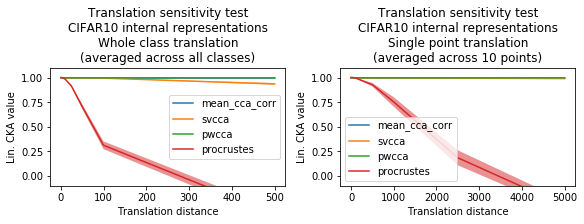

In [30]:
# CIFAR10 all classes and outliers
dists_class = 7
dists_pt = 10
cifar_distances = [1, 5, 10, 25, 50, 100, 500, 1000, 2500, 5000, 7500, 1e4, 1.5e4, 2e4, 5e4, 1e5]

fig, ax = plt.subplots(1,2, figsize=(8,3), constrained_layout=True)

for idx, rep_sim_mes in enumerate(rep_sim_measures):
    cifar_classes_means_ = np.mean(one_class_data[idx], axis = 1)[1:]
    cifar_classes_means = np.mean(cifar_classes_means_, axis=0)[0:dists_class,1]
    cifar_classes_stds = np.std(cifar_classes_means_, axis=0)[0:dists_class,1]

    cifar_outlier_means = np.mean(one_pt_data[idx], axis = 0)[:dists_pt,1]
    cifar_outlier_stds = np.std(one_pt_data[idx], axis = 0)[:dists_pt,1]
    
    ax[0].plot(cifar_distances[:dists_class], cifar_classes_means, label = rep_sim_mes)
    ax[0].fill_between(cifar_distances[:dists_class], cifar_classes_means-cifar_classes_stds, cifar_classes_means+cifar_classes_stds, alpha = 0.5)
    ax[0].legend()
    ax[0].set_xlabel('Translation distance')
    ax[0].set_ylabel('Lin. CKA value')
    ax[0].set_title('Translation sensitivity test\nCIFAR10 internal representations\nWhole class translation\n(averaged across all classes)')


    ax[1].plot(cifar_distances[:dists_pt], cifar_outlier_means, label = rep_sim_mes)
    ax[1].fill_between(cifar_distances[:dists_pt], cifar_outlier_means-cifar_outlier_stds, cifar_outlier_means+cifar_outlier_stds, alpha = 0.5)
    ax[1].legend()
    ax[1].set_xlabel('Translation distance')
    ax[1].set_ylabel('Lin. CKA value')
    ax[1].set_title('Translation sensitivity test\nCIFAR10 internal representations\nSingle point translation\n(averaged across 10 points)')


ax[0].axis([None, None, -0.1,1.1 ])
ax[1].axis([None, None, -0.1,1.1 ])
# ax.set_xlabel('Translation distance')
# ax.set_ylabel('Similarity value')
# ax.set_title('a) Subset translation sensitivity test\npoints sampled from two cubes')
# ax.legend()

In [22]:
one_class_data[1][0]

array([[[0.91258   , 1.        ],
        [0.91258   , 1.        ],
        [0.91258   , 1.        ],
        [0.91258   , 0.99999999],
        [0.91258   , 0.99999997],
        [0.91258   , 0.99999991],
        [0.91258   , 0.99999894],
        [0.91258   , 0.99999579],
        [0.91258   , 0.99995061],
        [0.91258   , 0.99975841],
        [0.9126    , 0.99954258],
        [0.9126    , 0.99892733],
        [0.91256   , 0.99839249],
        [0.91256   , 0.99857099]],

       [[0.91258   , 1.        ],
        [0.91258   , 1.        ],
        [0.91258   , 1.        ],
        [0.91258   , 0.99999999],
        [0.91258   , 0.99999997],
        [0.91258   , 0.99999991],
        [0.91258   , 0.99999898],
        [0.91258   , 0.9999957 ],
        [0.91258   , 0.99994664],
        [0.91258   , 0.99973016],
        [0.9126    , 0.99951367],
        [0.9126    , 0.99662546],
        [0.91256   , 0.99829074],
        [0.91256   , 0.99843702]],

       [[0.91258   , 1.        ],
        [0